In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
import matplotlib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import SVG
import keras.backend as K
from keras.layers import Input, Dense, LSTM, GRU, Embedding, Activation, Lambda
from keras.models import Model, load_model
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.utils.vis_utils import model_to_dot
from tqdm import tqdm,trange

Using TensorFlow backend.


# Set parameters

In [2]:
num_train_examples = 150000
max_train_length = 10

num_test_examples = 10000
min_test_length=5
max_test_length=55
step_test_length=5

# Load MNIST

In [3]:
def load_mnist(pack=0):
    with open('/home/skottur/florainritter/code/data/mnist/mnist8m_{0}_features.bin'.format(pack), 'r') as f:
        v = np.fromfile(f, dtype='int32', count=1)
        D = np.asscalar( np.fromfile(f, dtype='int32', count=1) )
        N = np.asscalar( np.fromfile(f, dtype='int32', count=1) )
        arr = np.fromfile(f).astype('float32')
    img = np.reshape(arr, (N,D))
    
    with open('/home/skottur/florainritter/code/data/mnist/mnist8m_{0}_labels.bin'.format(pack), 'r') as f:
        v = np.fromfile(f, dtype='int32', count=1)
        D = np.asscalar( np.fromfile(f, dtype='int32', count=1) )
        N = np.asscalar( np.fromfile(f, dtype='int32', count=1) )
        arr = np.fromfile(f).astype('float32')
    label = np.reshape(arr, (N,D))
    
    return img, label

Generate train data

In [4]:
img, label = load_mnist(0)

# Random shuffle of data
rng_state = np.random.get_state()
np.random.shuffle(img)
np.random.set_state(rng_state)
np.random.shuffle(label) 

X = np.zeros((num_train_examples,max_train_length))
sum_X = np.zeros((num_train_examples))
m = 0
for i in tqdm(range(num_train_examples), desc='Generating train examples: '):
    n = np.random.randint(1,max_train_length)
    for j in range(1,n+1):
        while label[m]==0.:
            m += 1
        X[i,-j] = m
        sum_X[i] += label[m]
        m += 1
img = img[:m]

Generating train examples: 100%|██████████| 150000/150000 [00:04<00:00, 33086.22it/s]


# Generate test data

In [5]:
def gen_test_data(num_examples, length):
    img, label = load_mnist(np.random.randint(1,8))
    Y = np.zeros((num_examples, length))
    sum_Y = np.zeros((num_examples))
    m = 0
    for i in range(num_examples):
        for j in range(1,length+1):
            while label[m]==0.:
                m += 1
            Y[i,-j] = m
            sum_Y[i] += label[m]
            m += 1
    return img[:m], Y, sum_Y

# DeepSet model

In [6]:
def get_deepset_model(images, max_length):
    input_img = Input(shape=(max_length,))
    x = Embedding(images.shape[0], images.shape[1], mask_zero=True, trainable=False)(input_img)
    x = Dense(300, activation='tanh')(x)
    x = Dense(100, activation='tanh')(x)
    x = Dense(30, activation='tanh')(x)
    Adder = Lambda(lambda x: K.sum(x, axis=1), output_shape=(lambda shape: (shape[0], shape[2])))
    x = Adder(x)
    encoded = Dense(1)(x)
    summer = Model(input_img, encoded)
    adam = Adam(lr=1e-3, epsilon=1e-3)
    summer.compile(optimizer=adam, loss='mae')
    summer.get_layer(index=1).set_weights([images])
    return summer

# LSTM model

In [7]:
def get_lstm_model(images, max_length):
    input_img = Input(shape=(max_length,))
    x = Embedding(images.shape[0], images.shape[1], mask_zero=True, trainable=False)(input_img)
    x = Dense(300, activation='tanh')(x) #One can try relu as well which results in similar performance
    x = Dense(100, activation='tanh')(x)
    x = LSTM(50)(x)
    x = Dense(30, activation='tanh')(x)
    encoded = Dense(1)(x)
    summer = Model(input_img, encoded)
    adam = Adam(lr=1e-3)
    summer.compile(optimizer=adam, loss='mae') #One can try mse as well which results in similar performance
    summer.get_layer(index=1).set_weights([images])
    return summer

# GRU model

In [8]:
def get_gru_model(images, max_length):
    input_img = Input(shape=(max_length,))
    x = Embedding(images.shape[0], images.shape[1], mask_zero=True, trainable=False)(input_img)
    x = Dense(300, activation='tanh')(x) #One can try relu as well which results in similar performance
    x = Dense(100, activation='tanh')(x)
    x = GRU(50)(x)
    x = Dense(30, activation='tanh')(x)
    encoded = Dense(1)(x)
    summer = Model(input_img, encoded)
    adam = Adam(lr=1e-3)
    summer.compile(optimizer=adam, loss='mae') #One can try mse as well which results in similar performance
    summer.get_layer(index=1).set_weights([images])
    return summer

# Train DeepSet model

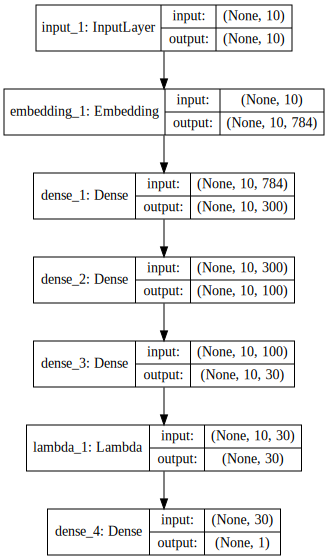

In [9]:
# model
K.clear_session()
model = get_deepset_model(img, max_train_length)

# visualize
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [10]:
# train
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, verbose=1, patience=20, min_lr=0.000001)

model.fit(X, sum_X, epochs=500, batch_size=128,
        shuffle=True, validation_split=0.0123456789,
        callbacks=[reduce_lr])

# save weights
deep_we = []
for i in [2,3,4,6]:
    w = model.get_layer(index=i).get_weights()
    deep_we.append(w)

Train on 148148 samples, validate on 1852 samples
Epoch 1/500
148148/148148 [==============================] - 8s 53us/step - loss: 2.3590 - val_loss: 1.4361
Epoch 2/500
148148/148148 [==============================] - 8s 51us/step - loss: 1.1923 - val_loss: 1.0133
Epoch 3/500
148148/148148 [==============================] - 8s 51us/step - loss: 0.8825 - val_loss: 0.7935
Epoch 4/500
148148/148148 [==============================] - 8s 51us/step - loss: 0.6810 - val_loss: 0.5835
Epoch 5/500
148148/148148 [==============================] - 8s 51us/step - loss: 0.5477 - val_loss: 0.5706
Epoch 6/500
148148/148148 [==============================] - 8s 51us/step - loss: 0.4518 - val_loss: 0.4390
Epoch 7/500
148148/148148 [==============================] - 8s 51us/step - loss: 0.3803 - val_loss: 0.3630
Epoch 8/500
148148/148148 [==============================] - 8s 51us/step - loss: 0.3256 - val_loss: 0.3185
Epoch 9/500
148148/148148 [==============================] - 8s 51us/step - loss: 0.27

Epoch 76/500
148148/148148 [==============================] - 7s 49us/step - loss: 0.0335 - val_loss: 0.0920
Epoch 77/500
148148/148148 [==============================] - 7s 49us/step - loss: 0.0313 - val_loss: 0.0978
Epoch 78/500
148148/148148 [==============================] - 7s 49us/step - loss: 0.0313 - val_loss: 0.0777
Epoch 79/500
148148/148148 [==============================] - 7s 49us/step - loss: 0.0328 - val_loss: 0.0875
Epoch 80/500
148148/148148 [==============================] - 7s 49us/step - loss: 0.0311 - val_loss: 0.0853
Epoch 81/500
148148/148148 [==============================] - 7s 49us/step - loss: 0.0319 - val_loss: 0.0718
Epoch 82/500
148148/148148 [==============================] - 7s 49us/step - loss: 0.0296 - val_loss: 0.0826
Epoch 83/500
148148/148148 [==============================] - 7s 49us/step - loss: 0.0299 - val_loss: 0.0618
Epoch 84/500
148148/148148 [==============================] - 7s 49us/step - loss: 0.0316 - val_loss: 0.0817
Epoch 85/500
148148

148148/148148 [==============================] - 7s 49us/step - loss: 0.0105 - val_loss: 0.0615

Epoch 00221: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
Epoch 222/500
148148/148148 [==============================] - 7s 49us/step - loss: 0.0103 - val_loss: 0.0616
Epoch 223/500
148148/148148 [==============================] - 7s 49us/step - loss: 0.0103 - val_loss: 0.0611
Epoch 224/500
148148/148148 [==============================] - 7s 49us/step - loss: 0.0103 - val_loss: 0.0613
Epoch 225/500
148148/148148 [==============================] - 7s 49us/step - loss: 0.0103 - val_loss: 0.0614
Epoch 226/500
148148/148148 [==============================] - 7s 49us/step - loss: 0.0103 - val_loss: 0.0613
Epoch 227/500
148148/148148 [==============================] - 7s 49us/step - loss: 0.0103 - val_loss: 0.0612
Epoch 228/500
148148/148148 [==============================] - 7s 49us/step - loss: 0.0103 - val_loss: 0.0613
Epoch 229/500
148148/148148 [=======================

148148/148148 [==============================] - 7s 49us/step - loss: 0.0101 - val_loss: 0.0613
Epoch 367/500
148148/148148 [==============================] - 7s 49us/step - loss: 0.0101 - val_loss: 0.0613
Epoch 368/500
148148/148148 [==============================] - 7s 49us/step - loss: 0.0101 - val_loss: 0.0613
Epoch 369/500
148148/148148 [==============================] - 7s 49us/step - loss: 0.0101 - val_loss: 0.0613
Epoch 370/500
148148/148148 [==============================] - 7s 49us/step - loss: 0.0101 - val_loss: 0.0613
Epoch 371/500
148148/148148 [==============================] - 7s 49us/step - loss: 0.0101 - val_loss: 0.0613
Epoch 372/500
148148/148148 [==============================] - 7s 49us/step - loss: 0.0101 - val_loss: 0.0613
Epoch 373/500
148148/148148 [==============================] - 7s 49us/step - loss: 0.0101 - val_loss: 0.0613
Epoch 374/500
148148/148148 [==============================] - 7s 49us/step - loss: 0.0101 - val_loss: 0.0613
Epoch 375/500
148148/148

# Train LSTM model

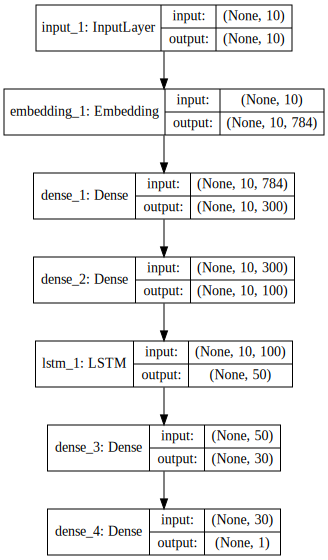

In [11]:
# model
K.clear_session()
model = get_lstm_model(img, max_train_length)

# visualize
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [12]:
# train
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, verbose=1, patience=10, min_lr=0.000001)

model.fit(X, sum_X, epochs=100, batch_size=128, # Fewer iterations, because each iteration is much more costlier
        shuffle=True, validation_split=0.0123456789,
        callbacks=[reduce_lr])

# save weights
lstm_we = []
for i in [2,3,4,5,6]:
    w = model.get_layer(index=i).get_weights()
    lstm_we.append(w)

Train on 148148 samples, validate on 1852 samples
Epoch 1/100
148148/148148 [==============================] - 58s 392us/step - loss: 8.4869 - val_loss: 3.1563
Epoch 2/100
148148/148148 [==============================] - 56s 377us/step - loss: 1.8508 - val_loss: 1.2662
Epoch 3/100
148148/148148 [==============================] - 57s 386us/step - loss: 0.9561 - val_loss: 0.8358
Epoch 4/100
148148/148148 [==============================] - 58s 390us/step - loss: 0.7147 - val_loss: 0.8012
Epoch 5/100
148148/148148 [==============================] - 57s 385us/step - loss: 0.5719 - val_loss: 0.6335
Epoch 6/100
148148/148148 [==============================] - 57s 385us/step - loss: 0.4920 - val_loss: 0.5452
Epoch 7/100
148148/148148 [==============================] - 57s 387us/step - loss: 0.4328 - val_loss: 0.4658
Epoch 8/100
148148/148148 [==============================] - 55s 368us/step - loss: 0.3870 - val_loss: 0.6349
Epoch 9/100
148148/148148 [==============================] - 58s 391us

# Train GRU model

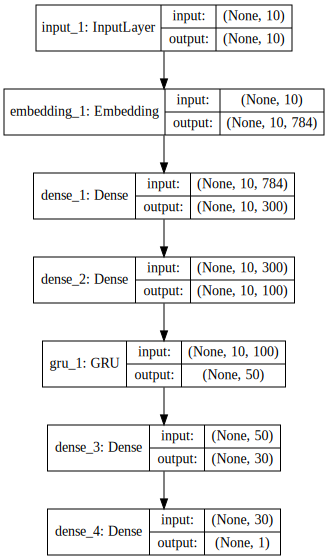

In [13]:
# model
K.clear_session()
model = get_gru_model(img, max_train_length)

# visualize
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [14]:
# train
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, verbose=1, patience=10, min_lr=0.000001)

model.fit(X, sum_X, epochs=100, batch_size=128, # Fewer iterations, because each iteration is much more costlier
        shuffle=True, validation_split=0.0123456789,
        callbacks=[reduce_lr])

# save weights
gru_we = []
for i in [2,3,4,5,6]:
    w = model.get_layer(index=i).get_weights()
    gru_we.append(w)

Train on 148148 samples, validate on 1852 samples
Epoch 1/100
148148/148148 [==============================] - 48s 325us/step - loss: 8.7294 - val_loss: 3.1632
Epoch 2/100
148148/148148 [==============================] - 48s 321us/step - loss: 1.8614 - val_loss: 1.2922
Epoch 3/100
148148/148148 [==============================] - 49s 333us/step - loss: 0.9580 - val_loss: 0.8394
Epoch 4/100
148148/148148 [==============================] - 50s 336us/step - loss: 0.6991 - val_loss: 0.9716
Epoch 5/100
148148/148148 [==============================] - 47s 320us/step - loss: 0.5808 - val_loss: 0.5831
Epoch 6/100
148148/148148 [==============================] - 48s 321us/step - loss: 0.4906 - val_loss: 0.6009
Epoch 7/100
148148/148148 [==============================] - 47s 317us/step - loss: 0.4418 - val_loss: 0.4104
Epoch 8/100
148148/148148 [==============================] - 46s 313us/step - loss: 0.4017 - val_loss: 0.4339
Epoch 9/100
148148/148148 [==============================] - 46s 309us

Epoch 73/100
148148/148148 [==============================] - 47s 320us/step - loss: 0.0565 - val_loss: 0.1476
Epoch 74/100
148148/148148 [==============================] - 46s 312us/step - loss: 0.0570 - val_loss: 0.1459
Epoch 75/100
148148/148148 [==============================] - 47s 318us/step - loss: 0.0559 - val_loss: 0.1452
Epoch 76/100
148148/148148 [==============================] - 47s 315us/step - loss: 0.0562 - val_loss: 0.1602
Epoch 77/100
148148/148148 [==============================] - 44s 300us/step - loss: 0.0549 - val_loss: 0.1466
Epoch 78/100
148148/148148 [==============================] - 46s 313us/step - loss: 0.0563 - val_loss: 0.1469
Epoch 79/100
148148/148148 [==============================] - 46s 307us/step - loss: 0.0545 - val_loss: 0.1481
Epoch 80/100
148148/148148 [==============================] - 48s 322us/step - loss: 0.0541 - val_loss: 0.1373
Epoch 81/100
148148/148148 [==============================] - 47s 319us/step - loss: 0.0551 - val_loss: 0.1617
E

# Evaluate models

In [15]:
metrics = {'deepsets': {'acc':[], 'mae':[], 'mse':[]}, 'lstm': {'acc':[],'mae':[], 'mse':[]}, 'gru': {'acc':[],'mae':[], 'mse':[]}}

lengths = range(min_test_length, max_test_length, step_test_length)
for l in tqdm(lengths):
    print('Evaluating at length: ', l)
    # generate test data
    img, Y, sum_Y = gen_test_data(num_test_examples, l)

    # model
    K.clear_session()
    model = get_deepset_model(img, l)

    # load weights
    for i, idx in enumerate([2,3,4,6]):
        model.get_layer(index=idx).set_weights(deep_we[i])

    # prediction
    preds = model.predict(Y, batch_size=128, verbose=1)
    metrics['deepsets']['acc'].append(1.0*np.sum(np.squeeze(np.round(preds))==sum_Y)/len(sum_Y))
    metrics['deepsets']['mae'].append(1.0*np.sum(np.abs(np.squeeze(preds)-sum_Y))/len(sum_Y))
    metrics['deepsets']['mse'].append(np.dot(np.squeeze(preds)-sum_Y, np.squeeze(preds)-sum_Y)/len(sum_Y))
    
    # model
    K.clear_session()
    model = get_lstm_model(img, l)

    # load weights
    for i, idx in enumerate([2,3,4,5,6]):
        model.get_layer(index=idx).set_weights(lstm_we[i])

    # prediction
    preds = model.predict(Y, batch_size=128, verbose=1)
    metrics['lstm']['acc'].append(1.0*np.sum(np.squeeze(np.round(preds))==sum_Y)/len(sum_Y))
    metrics['lstm']['mae'].append(1.0*np.sum(np.abs(np.squeeze(preds)-sum_Y))/len(sum_Y))
    metrics['lstm']['mse'].append(np.dot(np.squeeze(preds)-sum_Y, np.squeeze(preds)-sum_Y)/len(sum_Y))
    
    # model
    K.clear_session()
    model = get_gru_model(img, l)

    # load weights
    for i, idx in enumerate([2,3,4,5,6]):
        model.get_layer(index=idx).set_weights(gru_we[i])

    # prediction
    preds = model.predict(Y, batch_size=128, verbose=1)
    metrics['gru']['acc'].append(1.0*np.sum(np.squeeze(np.round(preds))==sum_Y)/len(sum_Y))
    metrics['gru']['mae'].append(1.0*np.sum(np.abs(np.squeeze(preds)-sum_Y))/len(sum_Y))
    metrics['gru']['mse'].append(np.dot(np.squeeze(preds)-sum_Y, np.squeeze(preds)-sum_Y)/len(sum_Y))

  0%|          | 0/10 [00:00<?, ?it/s]

Evaluating at length:  5
10000/10000 [==============================] - 1s 55us/step


 10%|█         | 1/10 [00:40<06:06, 40.67s/it]

Evaluating at length:  10
10000/10000 [==============================] - 1s 88us/step


 20%|██        | 2/10 [01:37<06:31, 48.94s/it]

Evaluating at length:  15
10000/10000 [==============================] - 1s 122us/step


 30%|███       | 3/10 [02:17<05:20, 45.78s/it]

Evaluating at length:  20
10000/10000 [==============================] - 2s 154us/step


 40%|████      | 4/10 [03:21<05:02, 50.43s/it]

Evaluating at length:  25
10000/10000 [==============================] - 2s 184us/step


 50%|█████     | 5/10 [04:22<04:22, 52.45s/it]

Evaluating at length:  30
10000/10000 [==============================] - 2s 223us/step


 60%|██████    | 6/10 [04:46<03:10, 47.71s/it]

Evaluating at length:  35
10000/10000 [==============================] - 3s 263us/step


 70%|███████   | 7/10 [05:19<02:17, 45.68s/it]

Evaluating at length:  40
10000/10000 [==============================] - 3s 296us/step


 80%|████████  | 8/10 [06:39<01:39, 49.96s/it]

Evaluating at length:  45
10000/10000 [==============================] - 3s 327us/step


 90%|█████████ | 9/10 [07:57<00:53, 53.10s/it]

Evaluating at length:  50
10000/10000 [==============================] - 3s 336us/step


100%|██████████| 10/10 [08:39<00:00, 51.92s/it]


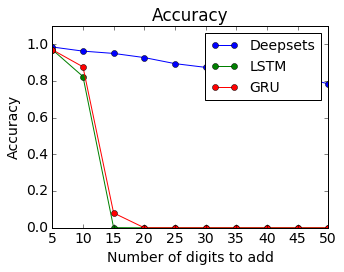

In [16]:
font = {'size': 14}
matplotlib.rc('font', **font)

scale = 0.5
plt.figure(figsize=(10*scale, 8*scale))

plt.plot(lengths, metrics['deepsets']['acc'], 'o-')
plt.plot(lengths, metrics['lstm']['acc'], 'o-')
plt.plot(lengths, metrics['gru']['acc'], 'o-')
plt.xlabel('Number of digits to add')
plt.ylabel('Accuracy')
plt.ylim( 0, 1.1 )
plt.xlim( 5, 50 )
plt.title('Accuracy')
plt.legend(['Deepsets', 'LSTM', 'GRU'], fontsize=14)
plt.tight_layout()
plt.show()

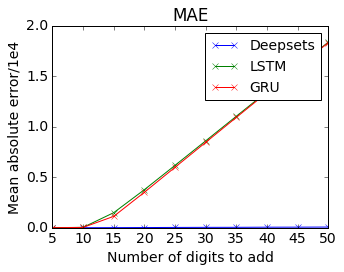

In [17]:
font = {'size': 14}
matplotlib.rc('font', **font)

scale = 0.5
plt.figure(figsize=(10*scale, 8*scale))

plt.plot(lengths, np.array(metrics['deepsets']['mae'])/1e2, 'x-')
plt.plot(lengths, np.array(metrics['lstm']['mae'])/1e2, 'x-')
plt.plot(lengths, np.array(metrics['gru']['mae'])/1e2, 'x-')
plt.xlabel('Number of digits to add')
plt.ylabel('Mean absolute error/1e4')
plt.title('MAE')
plt.legend(['Deepsets', 'LSTM', 'GRU'], fontsize=14)
plt.tight_layout()
plt.show()

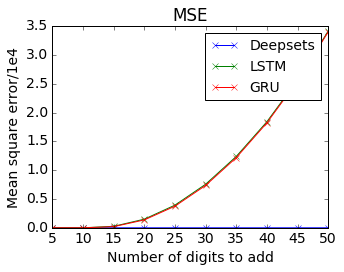

In [18]:
font = {'size': 14}
matplotlib.rc('font', **font)

scale = 0.5
plt.figure(figsize=(10*scale, 8*scale))

plt.plot(lengths, np.array(metrics['deepsets']['mse'])/1e4, 'x-')
plt.plot(lengths, np.array(metrics['lstm']['mse'])/1e4, 'x-')
plt.plot(lengths, np.array(metrics['gru']['mse'])/1e4, 'x-')
plt.xlabel('Number of digits to add')
plt.ylabel('Mean square error/1e4')
plt.title('MSE')
plt.legend(['Deepsets', 'LSTM', 'GRU'], fontsize=14)
plt.tight_layout()
plt.show()